# Load Libraries and Data

In [1]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
plt.style.use('dark_background')

import plotly.express as px
import plotly.io as pio
pio.templates.default = 'plotly_dark'

import seaborn as sns

In [2]:
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')
tags = pd.read_csv('tags.csv')

# Data Decription and Goal

## Description

This data is collected from the MovieLens dataset, which is created and curated by a research lab known as Grouplens Research. Grouplens Research is associated with the equally named website "Grouplens", which describes itself as 'a web site that helps people find movies to watch." 
<hr>
The data is composed of 100,000 ratings and 3,600 tag applications applied to 9,000 movies by 600 users. It was last update in September of 2018.


The data files used are the 'movies.csv, 'ratings.csv', and 'tags.csv' from the "Small" version of the dataset.

## Goal

Using this data, the goal of this project is to create both a Collaborative and Content-based recommender system. 

# Data Inspection and EDA

## Data Wrangling

In [3]:
# Inspect shape and structure of the DataFrame
print(movies.shape)

# Check for missing values
display(movies.isna().sum())
movies.head()

# Change index so we can merge based on movieId later
movies = movies.set_index('movieId')
# movies.head()

(9742, 3)


movieId    0
title      0
genres     0
dtype: int64

In [4]:
# Investigate the shape and structure of the ratings df
print(ratings.shape)

# Check for missing values
display(ratings.isna().sum())
# ratings.head()

(100836, 4)


userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

## EDA

### Manipulating Data

In [5]:
# Let's merge the DataFrames based on the movieId column
df = pd.merge(left=movies, right=ratings, on='movieId')

# Let's make the genres column easier to work with
df['genres'] = df.genres.str.split('|')

# Let's create a dictionary that counts how many occurences of each genre there are
Children = 0
Crime = 0
Romance = 0
Western = 0
Documentary = 0
Sci_Fi = 0
War = 0
Film_Noir = 0
Musical = 0
Thriller = 0
Adventure = 0
Horror = 0
Action = 0
Comedy = 0
no_genres_listed = 0
Animation = 0
Fantasy = 0
Drama = 0
IMAX = 0
Mystery = 0

for x in df.genres:
    for a in x:
        if a == 'Children':
            Children += 1
        elif a == 'Crime':
            Crime += 1
        elif a == 'Romance':
            Romance += 1
        elif a == 'Western':
            Western =+ 1
        elif a == 'Documentary':
            Documentary += 1
        elif a == 'Sci-Fi':
            Sci_Fi += 1
        elif a == 'War':
            War += 1
        elif a == 'Film-Noir':
            Film_Noir += 1
        elif a == 'Musical':
            Musical += 1
        elif a == 'Thriller':
            Thriller += 1
        elif a == 'Adventure':
            Adventure += 1
        elif a == 'Horror':
            Horror += 1
        elif a == 'Action':
            Action += 1
        elif a == 'Comedy':
            Comedy += 1
        elif a == '(no genres listed)':
            no_genres_listed += 1
        elif a == 'Animation':
            Animation += 1
        elif a == 'Fantasy':
            Fantasy += 1
        elif a == 'Drama':
            Drama += 1
        elif a == 'IMAX':
            IMAX += 1
        elif a == 'Mystery':
            Mystery += 1
dic = {'Children':Children,
 'Crime':Crime,
 'Romance':Romance,
 'Western':Western,
 'Documentary':Documentary,
 'Sci-Fi':Sci_Fi,
 'War':War,
 'Film-Noir':Film_Noir,
 'Musical':Musical,
 'Thriller':Thriller,
 'Adventure':Adventure,
 'Horror':Horror,
 'Action':Action,
 'Comedy':Comedy,
 '(no genres list:ed)':no_genres_listed,
 'Animation':Animation,
 'Fantasy':Fantasy,
 'Drama':Drama,
 'IMAX':IMAX,
 'Mystery':Mystery}

# Let's create a column that shows us the year that each of these movies were published
years = []
for title in df['title']:
    year_subset = title[-5:-1]
    try: years.append(int(year_subset))
    except: years.append(0)
df['Year of Publication'] = years

# Let's exclude the movies without a year of publication since there are only 30 of them
df = df[df['Year of Publication'] != 0]

In [6]:
# Let's check how many movies are in our DataFrame
a = df['movieId'].nunique()
print(f'There are {a} total movies in the DataFrame!')

# Let's see how many unique genres there are

print('No of unique genres in the DATAFRAME is:', len(list(dic.keys())))

There are 9701 total movies in the DataFrame!
No of unique genres in the DATAFRAME is: 20


### Visualizations and EDA

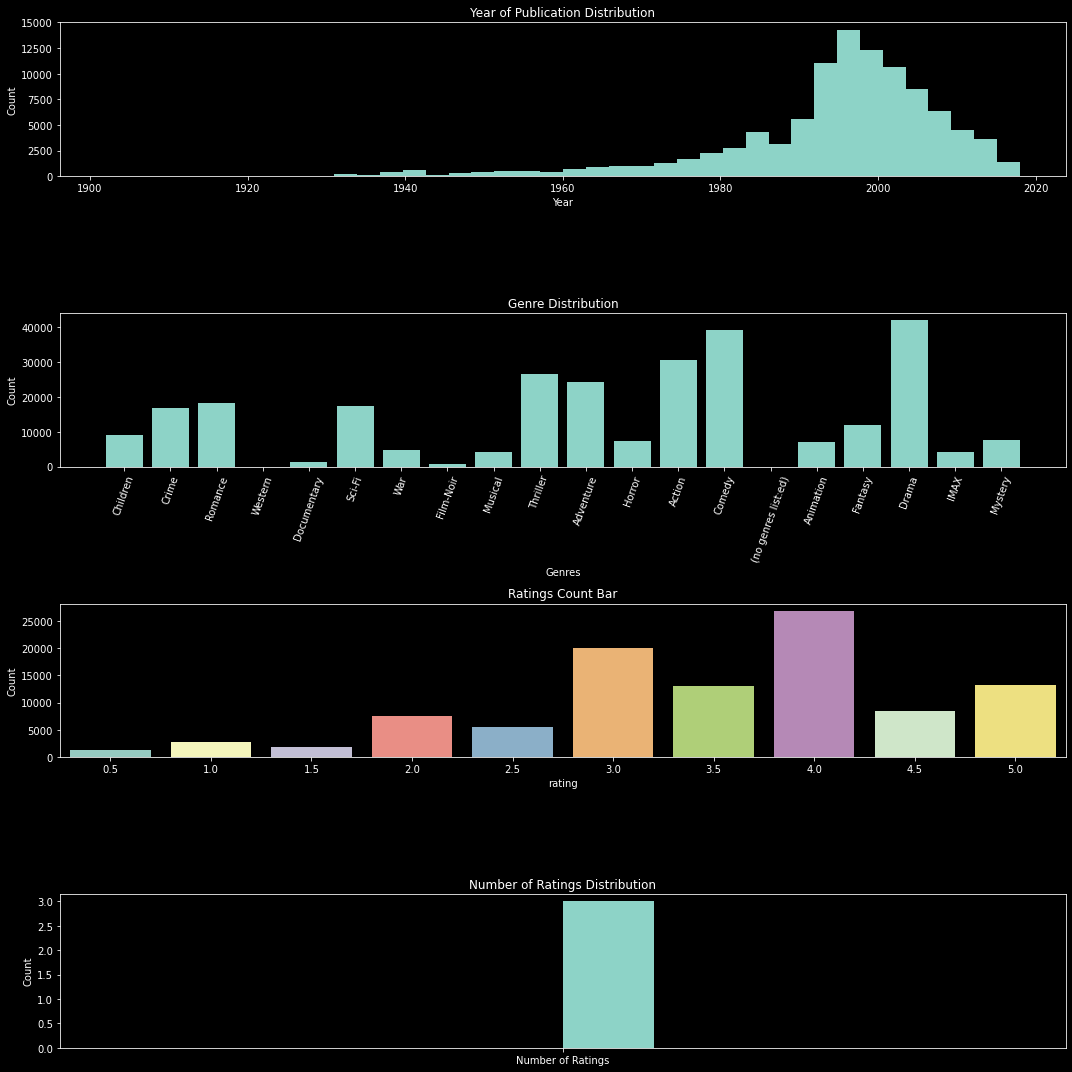

In [46]:
fig, ax = plt.subplots(4,1,figsize=(15, 15))

# Plot year distribution
ax[0].hist(x=df['Year of Publication'], bins=40)
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Count')
ax[0].set_title('Year of Publication Distribution')

# Plot genre distribution
ax[1].bar(dic.keys(), dic.values())
ax[1].set_xlabel('Genres')
ax[1].set_title('Genre Distribution')
ax[1].set_xticks(ticks=list(dic.keys()))
ax[1].set_xticklabels(labels = list(dic.keys()),rotation=70)
ax[1].set_ylabel('Count')

# Plot rating distribution
result1 = df.groupby(['rating']).size()
sns.barplot(x = result1.index, ax=ax[2],  y=result1.values).set_title('Ratings Count Bar')
ax[2].set_ylabel('Count')

# Plot the number of ratings distibution
num = pd.DataFrame(df.groupby('movieId').count()['rating']).reset_index()
df = pd.merge(left=df, right=num, on='movieId')
df.rename(columns={'rating_x': 'rating', 'rating_y': 'Number of Ratings'}, inplace=True)

ax[3].hist(df['Number of Ratings'])
ax[3].set_ylabel('Count')
ax[3].set_title('Number of Ratings Distribution')

plt.tight_layout()

plt.savefig('EDA')


Using these visualizations, we can make several conclusions concerning the data!
1. Most movies in this dataset were made around the year 2000. 
2. The three most frequent genres are drama, comedy, and action. There are no surprises there, as Western films tend to lean towards these highly successful genre choices. 
3. Most of the movies were rate at a 3 or a 4. Many less movies were rated between 0.5 and 2.5, which potentially indicates that this dataset had a decent selection of movies!
4. A lot of movies didn't have a lot of ratings. The most ratings you'll find for one movie is roughly 300 ratings. On average, movies were rated between 1 and 50 times!


# Modeling the Recommendation Systems

In [8]:
from surprise.model_selection import train_test_split
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline, KNNWithZScore
from surprise.prediction_algorithms import SVD
from surprise.model_selection import GridSearchCV
from surprise.model_selection import cross_validate
from surprise import SVD, SVDpp, NMF
from surprise import SlopeOne, CoClustering

**EVALUTATION METRIC**
<br>

For our modeling, we will be using RMSE for our data! RMSE is an excellent evaluation metric for when you want to penalize larger errors. This means that it is best to use RMSE if a bigger error means more to your problem in context than a smaller error. If a smaller error were to be just as detrimental as a larger error, then MAE could be used.

In our case, we are using ratings. Let's say a user gave a rating of 10, and we had two models, with model 1 predicting a rating of 5 and model 2 predicting a rating of 2. Model 2 has a larger error, in the context of ratings, this means a lot. A movie with a recommendation of 2/10 is abysmal, while a movie with a recommendation of 5 can be considered mediocre. For all of us movie watchers, those ratings say very different things! This insinuates that larger error has a larger effect on the problem in context, and therefore RMSE is preferred.

### Collaborative Filtering 

Collaborative filtering is the most common form of recommendation systems. So common, that it is usually insinuated that you are using collaborative filtering when you are referencing recommendation systems in general. The idea is that you take the information concerning user's preferences and a specific metric such as "ratings", and convert this information for ALL users into a matrix. This matrix will have missing value for the items that a customer did not rate, and the job of the recommendation system is to use the data to find these missing values, and then make recommendations based on the findings. 
<br>

So if there were 5 movies that a person had not seen yet, and the recommendation system gave the 5 movies a rating of 1/5, 2/5, 3/5, 4/5, 5/5 respectively, the recommender system would choose the movie that it predicts the person would rate the highest: in other words, it would recommend the movie that it thinks you would like most!!

In [9]:
reader = Reader(rating_scale=(0.5,5))
data = Dataset.load_from_df(ratings.drop('timestamp', axis=1), reader)

trainset = data.build_full_trainset()
print('Number of users: ', trainset.n_users, '\n')
print('Number of items: ', trainset.n_items)

Number of users:  610 

Number of items:  9724


In [10]:
# kNN based
knnbasic_cv = cross_validate(KNNBasic(), data, cv=5, n_jobs=5, verbose=False)
knnmeans_cv = cross_validate(KNNWithMeans(), data, cv=5, n_jobs=5, verbose=False)
knnz_cv = cross_validate(KNNWithZScore(), data, cv=5, n_jobs=5, verbose=False)

In [11]:
# Matrix Factorization Based
svd_cv = cross_validate(SVD(), data, cv=5, n_jobs=5, verbose=False)
svdpp_cv = cross_validate(SVDpp(), data, cv=5, n_jobs=5, verbose=False)
nmf_cv = cross_validate(NMF(), data, cv=5, n_jobs=5, verbose=False)

In [12]:
# Other
slope_cv = cross_validate(SlopeOne(), data, cv=5, n_jobs=5, verbose=False)
coclus_cv = cross_validate(CoClustering(), data, cv=5, n_jobs=5, verbose=False)

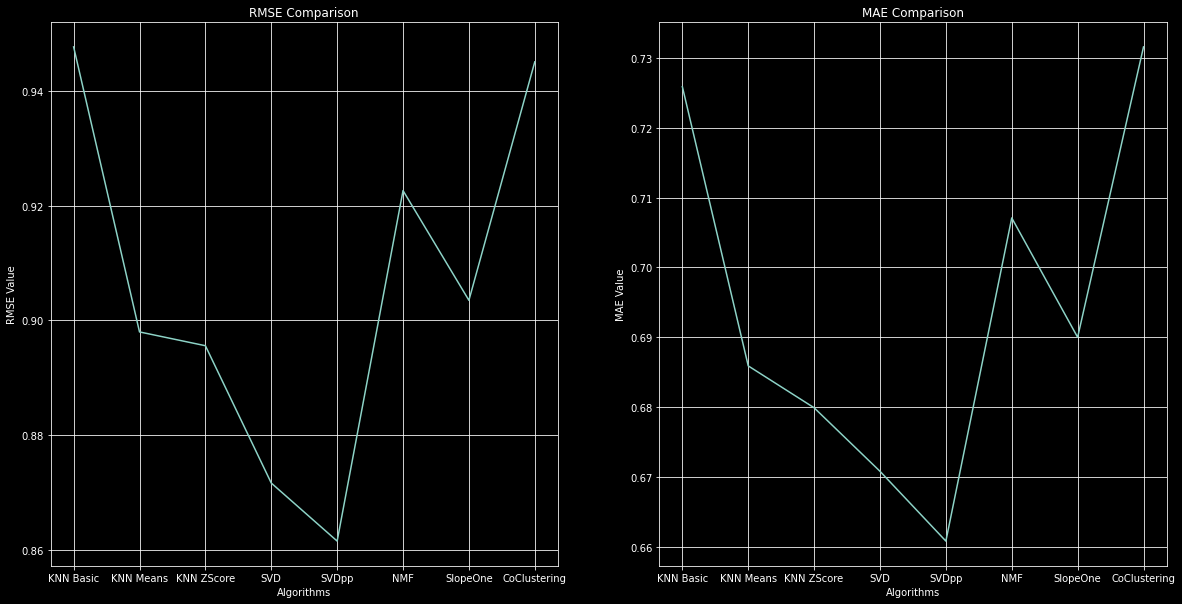

In [44]:
x_algo = ['KNN Basic', 'KNN Means', 'KNN ZScore', 'SVD', 'SVDpp', 'NMF', 'SlopeOne', 'CoClustering']
all_algos_cv = [knnbasic_cv, knnmeans_cv, knnz_cv, svd_cv, svdpp_cv, nmf_cv, slope_cv, coclus_cv]

rmse_cv = [round(res['test_rmse'].mean(), 4) for res in all_algos_cv]
mae_cv = [round(res['test_mae'].mean(), 4) for res in all_algos_cv]

fig, ax = plt.subplots(1, 2, figsize=(20,10))

ax[0].plot(x_algo, rmse_cv, label='RMSE')
ax[0].set_title('RMSE Comparison')
ax[0].set_xlabel('Algorithms')
ax[0].set_ylabel('RMSE Value')


ax[1].plot(x_algo, mae_cv, label='MAE')
ax[1].set_title('MAE Comparison')
ax[1].set_xlabel('Algorithms')
ax[1].set_ylabel('MAE Value')

ax[0].grid()
ax[1].grid()

plt.savefig('comparisons.png')
# plt.show()

Using the cross-validation MAE and RMSE scores across a total of 8 different models, it is clear that the best performing model is the SVDpp model. The second most effective is the SVD model, and the third is the KNN ZScore model. For our final model, we will focus on the SVDpp model!

In [14]:
final_model = SVDpp()
grid = {'n_epochs': [5, 10, 20, 30], 
        'lr_all': [.0025, .005, .001, .01]}
gs = GridSearchCV(SVD, grid, cv=5)
gs.fit(data)

print(gs.best_score)
print(gs.best_params)

{'rmse': 0.8728528701382426, 'mae': 0.6707950212757082}
{'rmse': {'n_epochs': 20, 'lr_all': 0.005}, 'mae': {'n_epochs': 30, 'lr_all': 0.005}}


In [15]:
j = SVDpp(n_epochs=10, lr_all=0.01)
j.fit(trainset)

In [34]:
# make predictions for the user
# you'll probably want to create a list of tuples in the format (movie_id, predicted_score)
list_of_movies = []
for m_id in movies.reset_index()['movieId'].unique():
    list_of_movies.append((m_id, j.predict(1000,m_id)[3]))
# order the predictions from highest to lowest rated
ranked_movies = sorted(list_of_movies, key=lambda x:x[1], reverse=True)

# return the top n recommendations using the 
def recommended_movies(user_ratings,movie_title_df,n):
        for idx, rec in enumerate(user_ratings):
            title = movie_title_df.loc[movies.reset_index()['movieId'] == int(rec[0])]['title']
            print(title)
            n-= 1
            if n == 0:
                break
            
recommended_movies(ranked_movies,movies.reset_index(),5)

277    Shawshank Redemption, The (1994)
Name: title, dtype: object
841    Streetcar Named Desire, A (1951)
Name: title, dtype: object
906    Lawrence of Arabia (1962)
Name: title, dtype: object
602    Dr. Strangelove or: How I Learned to Stop Worr...
Name: title, dtype: object
680    Philadelphia Story, The (1940)
Name: title, dtype: object


### Content-Based Filtering

With content-based filtering algorithms, you are given user's preferences, and then using those preferences, you identify items that relate most closely to the attributes of the preferred items.
<br>

Here is an example:
<br>

You decide to watch a Disney movie on Netflix. Netflix then could use a content-based filtering method to make recommendations of movies with similar attributes to a Disney movie.
<br>

What attributes does a Disney movie have? Some could say a Disney movie could be described as:
- Funny
- Musical
- Inspiring
Also a genre could be specified, such as being in the "family" genre
<br>

So the recommendation system will use these attributes and find other movies with the same attributes or similar ones!
<br>

For our recommendation system, we will not have to use the "tags" DataFrame that we did not use in our previous recommendation system that used collaborative filtering.

In [37]:
# Create new DataFrame that incorporates tags
movies.reset_index().drop_duplicates(subset='movieId', inplace=True)
tags.drop_duplicates(subset='movieId', inplace=True)
content_df = pd.merge(left=movies, right=tags, on='movieId')

# Make a new column that combines all attributes (genres and tags)
content_df['genres'] = content_df['genres'].apply(lambda x: ''.join(x.replace('|', ' ')).lower())
def comb(row):
    return row['genres']+' '+row['tag']
content_df['genres and tags'] = content_df.apply(comb, axis=1)

# Import TfidfVectorizer and linear_kernel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel 

# Instantiate and fit_transform vectorizer
tf = TfidfVectorizer()
tfidf_matrix = tf.fit_transform(content_df['genres and tags'])

# Construct similarity matrix
from sklearn.metrics.pairwise import cosine_similarity
similarity_matrix = cosine_similarity(tfidf_matrix)

#movies index mapping
similarity_matrix.shape

(1572, 1572)

In [41]:
def recommend(title, num, cosine_sim = similarity_matrix):
    recommended_movies = []
    index = content_df[content_df['title'] == title].index[0]
    similarity_scores = pd.Series(similarity_matrix[index]).sort_values(ascending = False)
    top_10_movies = list(similarity_scores.iloc[1:num+1].index)
    for i in top_10_movies:
        recommended_movies.append(list(content_df['title'])[i])
    return recommended_movies

In [43]:
recommend('Toy Story (1995)', 15)

["Bug's Life, A (1998)",
 'Toy Story 2 (1999)',
 'Sintel (2010)',
 'Up (2009)',
 'Jumanji (1995)',
 'Chronicles of Narnia: Prince Caspian, The (2008)',
 'Watership Down (1978)',
 'Cat Returns, The (Neko no ongaeshi) (2002)',
 "Kiki's Delivery Service (Majo no takkyûbin) (1989)",
 'Alice in Wonderland (1951)',
 'Sinbad: Legend of the Seven Seas (2003)',
 'Who Framed Roger Rabbit? (1988)',
 'Finding Nemo (2003)',
 'Croods, The (2013)',
 'The Lego Movie (2014)']